In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from df_utils import get_companies_list, get_X_y
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, \
                            precision_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest

#### Load the dataframe and companies with not too many nans

In [2]:
df, companies = get_companies_list(2)
# learner history parameters
nhist = 10
nfut = 2
totHist = int(3*365)

comp_dict = {}
for i, comp in enumerate(companies):
    comp_dict[comp] = get_X_y(df, comp, nfut, nhist, totHist)

#### Drop some columns:

In [3]:
X_orig, y, ysim = comp_dict[comp]
print(X_orig.columns.values)
print(y.columns.values)
print(ysim.columns.values)

include = ['c_oend_%', 'c_slow_%', 'c_shigh_%', 'change_Me', 'offer_sell_', 'offer_buy_'] #['c_shigh_', 'c_slow_', 'offer_sell_', 'offer_buy_', 'sales_low_', 'sales_high_']
cols_keep = [col for col in X_orig.columns if col[:-4] in include] 
y_cols = ['offer_end_change', 'sale_low_change', 'sale_high_change']

['offer_end_-01' 'offer_end_-02' 'offer_end_-03' 'offer_end_-04'
 'offer_end_-05' 'offer_end_-06' 'offer_end_-07' 'offer_end_-08'
 'offer_end_-09' 'offer_end_-10' 'offer_buy_-01' 'offer_buy_-02'
 'offer_buy_-03' 'offer_buy_-04' 'offer_buy_-05' 'offer_buy_-06'
 'offer_buy_-07' 'offer_buy_-08' 'offer_buy_-09' 'offer_buy_-10'
 'offer_sell_-01' 'offer_sell_-02' 'offer_sell_-03' 'offer_sell_-04'
 'offer_sell_-05' 'offer_sell_-06' 'offer_sell_-07' 'offer_sell_-08'
 'offer_sell_-09' 'offer_sell_-10' 'sales_low_-01' 'sales_low_-02'
 'sales_low_-03' 'sales_low_-04' 'sales_low_-05' 'sales_low_-06'
 'sales_low_-07' 'sales_low_-08' 'sales_low_-09' 'sales_low_-10'
 'sales_high_-01' 'sales_high_-02' 'sales_high_-03' 'sales_high_-04'
 'sales_high_-05' 'sales_high_-06' 'sales_high_-07' 'sales_high_-08'
 'sales_high_-09' 'sales_high_-10' 'change_Me_-01' 'change_Me_-02'
 'change_Me_-03' 'change_Me_-04' 'change_Me_-05' 'change_Me_-06'
 'change_Me_-07' 'change_Me_-08' 'change_Me_-09' 'change_Me_-10'
 'c_s

### Plot pictures:

In [4]:
def plot_sim(comp, ysim, ndays, *args):
    
    
    plt.figure(figsize = (12,6))
    x = pd.to_datetime(ysim.index, format = '%d.%m.%Y')[:ndays]
    yl = ysim['sales_low_000'].values[:ndays]
    yh = ysim['sales_high_000'].values[:ndays]
    #y = ysim['offer_end_prev'].values[:ndays]
    
    #plt.plot_date(x,y, linestyle = '-', marker = None)
    plt.fill_between(x,yl,yh, linestyle = '-')
    plt.ylabel('Sales lowest to highest filled')
    #[plt.gca().axvline(xi, alpha = .1) for xi in x]
    
    if len(args) == 3:
        pred, truth, col = [arg[:ndays] for arg in args]
        
        correct = pred & truth
        fp = pred & np.logical_not(truth)
        
        plt.scatter(x[correct], yh[correct], s = 40, alpha = .7, 
                    c = 'green', label = col + ' correct')
        plt.scatter(x[truth], yh[truth], s = 20, c = 'red', alpha = .2,
                    label = col + ' true')
        
    else:    
        plt.twinx()
        y2 = ysim['offer_end_change']*100
        plt.plot_date(x,y2, linestyle = '-', marker = None, color = 'red')
        plt.ylabel('Offer end percentage change')
    
    plt.legend(frameon = False)
    plt.title(comp, fontsize = 14)
    plt.show()
   

### Make estimator pipe

In [5]:
pipe_rf = Pipeline([('pol', PolynomialFeatures(degree = 2, interaction_only = True)),
                    ('var', VarianceThreshold()),
                    ('sel', SelectKBest()),
                    ('rf', RandomForestClassifier())]) 

params_rf = [{'sel__k': np.arange(40,100,10),
              'rf__max_features': np.arange(5,30,5),
              'rf__max_depth': [5,10,20],
              'rf__n_estimators': [20,50,100]}]

pipe_gbm = Pipeline([('pol', PolynomialFeatures(degree = 2, interaction_only = True)),
                     ('var', VarianceThreshold()),
                     ('sel', SelectKBest()),
                     ('gbm', GradientBoostingClassifier())]) 

params_gbm = [{'sel__k': np.arange(20,50,10),
               'gbm__learning_rate': np.linspace(.05,.4, 8),
               'gbm__max_depth': [3,5],
               'gbm__n_estimators': np.arange(50, 200, 25) }]


def get_pipe(key):
    if key == 'rf':
        return pipe_rf, params_rf
    elif key == 'gbm':
        return pipe_gbm, params_gbm


### Make custom fit for each company:

In [6]:
def comp_estimator(comp, y, threshold, pipe, params, ntest = 50, metric = 'roc_auc'):
    
    splitter = StratifiedKFold(n_splits = 5, shuffle = True) #, random_state = 0)
    X,_,ysim = comp_dict[comp]
    X = X[cols_keep]
    
    y_bin = threshold < y
    
    X_test, y_test = X[:ntest], y_bin[:ntest]
    X_train, y_train = X[ntest:], y_bin[ntest:]
    Xy = [X_train, X_test, y_train, y_test, ysim, y_bin]
    
    
    grid = GridSearchCV(pipe, params, scoring = metric, n_jobs = 5, 
                        cv = splitter, verbose = 1)
    grid.fit(X_train, y_train)
    
    return Xy, grid.best_estimator_, grid.best_params_, grid.best_score_


def get_scores(y_pred_train, y_pred_test, y_pred_train_p, 
               y_pred_test_p, y_train, y_test, show_report = False):
    try:
        roc_auc_test = roc_auc_score(y_test, y_pred_test_p)
    except ValueError as e:
        print(e)
        roc_auc_test = -1
    
    precision_test = precision_score(y_test, y_pred_test)
    
    if show_report:
        print('Train set classification')
        print(classification_report(y_train, y_pred_train, target_names = ['not rise', 'rise']))
        print(confusion_matrix(y_train, y_pred_train))
        print('Train roc_auc = {:.3f}'.format(roc_auc_score(y_train, y_pred_train_p)))
        print('\nTest set classification')
        print(classification_report(y_test, y_pred_test, target_names = ['not rise', 'rise']))
        print(confusion_matrix(y_test, y_pred_test))
        print('Test roc_auc = {:.3f}\n'.format(roc_auc_test))
    
    return roc_auc_test, precision_test

def get_prediction(Xy, estimator, show_report = False):
    
    X_train, X_test, y_train, y_test = Xy[:4]
    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)
    y_pred_train_p = estimator.predict_proba(X_train)[:,1]
    y_pred_test_p = estimator.predict_proba(X_test)[:,1]
    
    
    return y_pred_train, y_pred_test, y_pred_train_p, y_pred_test_p


### Feed the pipe to fit for each company and collect the results

In [7]:
def fit_and_report(companies, key = 'rf', ntest = 100, show = False):
    
    thres = {'offer_end_change':.0, 
             'sale_low_change+1':.0,
             'sale_low_change':.0,
             'sale_high_change':.0}
    
    pipe, params = get_pipe(key)
    
    try:
        results_dict = np.load('opm_params_{}.npy'.format(key)).item()        
    except FileNotFoundError:
        results_dict = {}
    
    for comp in companies:
        y = comp_dict[comp][1]
        for col in y.columns.values:
            try:
                results_dict[comp][col]
            except KeyError:
                
                
                print(comp, ' ', col)

                X,_,ysim = comp_dict[comp]
                X = X[cols_keep]

                Xy, estimator_r, params_opm_r, score_r \
                    = comp_estimator(comp, y[col].values,
                                     thres[col], pipe, params,
                                     ntest = ntest,
                                     metric = 'roc_auc')

                y_pred_train, y_pred_test, y_pred_train_p, y_pred_test_p \
                    = get_prediction(Xy, estimator_r)

                roc_auc, precision = get_scores(y_pred_train, 
                                                y_pred_test, 
                                                y_pred_train_p, 
                                                y_pred_test_p, 
                                                Xy[2], Xy[3], 
                                                show_report = show)

                if show:
                    print(params_opm_r)
                    y_pred_tot = np.concatenate((y_pred_test, 
                                                 y_pred_train))
                    plot_sim(comp, Xy[4], ntest*4, y_pred_tot, 
                             Xy[5], col)


                col_dict = {col: {'roc_auc':roc_auc, 
                                  'precision':precision,
                                  'threshold':thres[col],
                                  'opm_params':params_opm_r}}
                try:
                    results_dict[comp].update(col_dict)
                except KeyError:
                    results_dict[comp] = col_dict
                 
                np.save('opm_params_{}'.format(key), results_dict)
    return results_dict


    

Aktia Pankki A   offer_end_change
Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   25.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  3.8min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  7.6min
[Parallel(n_jobs=5)]: Done 2520 out of 2520 | elapsed:  8.0min finished


Train set classification
             precision    recall  f1-score   support

   not rise       1.00      1.00      1.00       507
       rise       1.00      1.00      1.00       518

avg / total       1.00      1.00      1.00      1025

[[507   0]
 [  0 518]]
Train roc_auc = 1.000

Test set classification
             precision    recall  f1-score   support

   not rise       0.59      0.34      0.43        38
       rise       0.48      0.72      0.57        32

avg / total       0.54      0.51      0.50        70

[[13 25]
 [ 9 23]]
Test roc_auc = 0.544

{'gbm__learning_rate': 0.22500000000000003, 'gbm__max_depth': 5, 'gbm__n_estimators': 75, 'sel__k': 70}


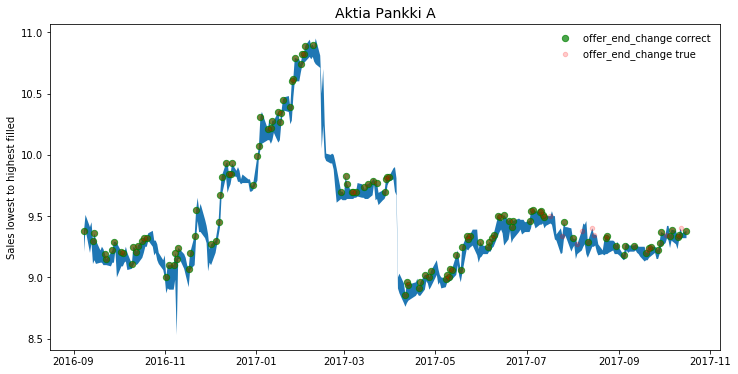

Aktia Pankki A   sale_low_change+1
Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   25.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  3.9min


In [ ]:
method_key = 'gbm'
results_dict = fit_and_report(companies, method_key, ntest = 70, show = True)

## Then test the obtained results:
### First make the prediction dataframe

In [13]:
# optimal parameters:
opm_params = np.load('opm_params_{}.npy'.format(method_key)).item()


def get_predictions(ntest, comp, col):
    
    X, y, ysim = comp_dict[comp]
    X = X[cols_keep]
    
    y_bin = opm_params[comp][col]['threshold'] < y[col]    
    X_test, y_test = X[:ntest], y_bin[:ntest]
    X_train, y_train = X[ntest:], y_bin[ntest:]
    
    pipe, _ = get_pipe(method_key)
    pipe.set_params(**opm_params[comp][col]['opm_params']) 
    pipe.fit(X_train, y_train)
    
    return pipe.predict(X_test)

def get_prediction_df(ntest):
    idx_tuples = [(comp, col) for comp in companies for col in y.columns]
    index = pd.MultiIndex.from_tuples(idx_tuples)
    
    
    pred_df = pd.DataFrame(index = comp_dict['Alma Media'][0].index[:ntest], columns = index)
    
    for comp in companies:
        ysim = comp_dict[comp][-1]

        for col in y.columns:
            pred_df[(comp, col)] = get_predictions(ntest, comp, col) #np.zeros(ntest)
        
        pred_df[(comp, 'sales_low_prev')] = ysim['sales_low_prev']
        pred_df[(comp, 'sales_high_prev')] = ysim['sales_high_prev']
        
        pred_df[(comp, 'sales_low_000'.format(nfut-1))] = ysim['sales_low_000'.format(nfut-1)]
        pred_df[(comp, 'sales_high_{:03d}'.format(nfut-1))] = ysim['sales_high_{:03d}'.format(nfut-1)]
        pred_df[(comp, 'offer_end_{:03d}'.format(nfut-1))] = ysim['offer_end_{:03d}'.format(nfut-1)]
    pred_df.index = comp_dict[comp][0].index.values[:ntest]
    return pred_df

df_pred = get_prediction_df(100) 


In [19]:
def simulate(pred_df):
    
    # Defines the condition when stock is bought
    buy_condition = {'sale_low_change+1':False, 'sale_high_change':True}
    fact = 1.

    for day in df_pred.index[::-1]:
        for comp in companies:
            # Condition to buy:
            if all([pred_df.loc[day, comp][key] == val for key,val in buy_condition.items()]):
                # Make sure today sale low is smaller than yesterday:
                buy_price = None
                sell_price = None
                if pred_df.loc[day, comp]['sales_low_000'] < pred_df.loc[day, comp]['sales_low_prev']:
                    buy_price = pred_df.loc[day, comp]['sales_low_prev']
                if pred_df.loc[day, comp]['sales_high_prev'.format(nfut-1)] \
                    < pred_df.loc[day, comp]['sales_high_{:03d}'.format(nfut-1)]: 
                    sell_price = pred_df.loc[day, comp]['sales_high_{:03d}'.format(nfut-1)]
                    
                else:
                    sell_price = pred_df.loc[day, comp]['offer_end_{:03d}'.format(nfut-1)]
                    print('Fell', buy_price, sell_price)
                if not any([buy_price == None, sell_price == None]):
                    fact *= 1 + (sell_price - buy_price)/buy_price
                    print(fact)
                    print()
simulate(df_pred)

Fell 3.53 3.52
0.99716713881

Fell 45.07 43.31
0.95822739698

Fell 43.27 43.17
0.956012866365

Fell None 8.64
Fell 7.88 7.85
0.952373223473

Fell 23.79 23.66
0.947168998208

Fell 1.76 1.77
0.952550640243

Fell None 5.78
Fell 25.35 25.45
0.956308236457

Fell 35.0 34.5
0.942646690222

Fell 9.85 9.89
0.946474697086

0.967100053681

Fell 40.0 40.0
0.967100053681

Fell 11.0 11.02
0.968858417415

0.98567887605

Fell None 6.13
Fell 39.4 39.72
0.993684389765

